In [14]:
**MiniProjectA**:  Hourly Wage Disparity between Fire/Police vs. Other Chicago City Departments.  

Hourly wage disparities between Fire/Police and other Chicago departments suggest a need to reassess funding. 
A linear regression model was used. 
Non-Fire/Police staff average $35.77/hour, while Fire/Police earn $7.21/hour more. 
Recomendation: Review crime trends and shift  Fire/Police funds to health and community programs tackling root causes.

See model and figure on line 12 and 13 below.

ERROR: Error in parse(text = input): <text>:1:1: unexpected '^'
1: **
    ^


In [1]:
library(tidyverse)
library(stargazer)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Please cite as: 


 Hlavac, Marek (2022). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.3. https://CRAN.R-project.org/package=stargazer 




In [2]:
options(width=120, repr.plot.width=8, repr.plot.height=3, repr.plot.res=200, jupyter.plot_mimetypes='image/png') # options for displaying outputs/graphs
theme_set(theme_light())

In [3]:
chicsal_df <- read_csv('data/chicago_salaries.csv')

Rows: 33183 Columns: 8
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (7): Name, JobTitle, Department, Time, PayType, Salary, Rate
dbl (1): Hours

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
chicsal_df %>% head(5)

Name,JobTitle,Department,Time,PayType,Hours,Salary,Rate
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>
"AARON, JEFFERY M",SERGEANT,POLICE,F,Salary,NA,$101442.00,NA
"AARON, KARINA",POLICE OFFICER (ASSIGNED AS DETECTIVE),POLICE,F,Salary,NA,$94122.00,NA
"AARON, KIMBERLEI R",CHIEF CONTRACT EXPEDITER,GENERAL SERVICES,F,Salary,NA,$101592.00,NA
"ABAD JR, VICENTE M",CIVIL ENGINEER IV,WATER MGMNT,F,Salary,NA,$110064.00,NA
"ABASCAL, REECE E",TRAFFIC CONTROL AIDE-HOURLY,OEMC,P,Hourly,20,NA,$19.86


In [5]:
library(dplyr)
library(readr)

# Convert salary and rate columns to numeric (remove $ and commas if present)
chicsal_df <- chicsal_df %>%
  mutate(
    Salary = readr::parse_number(Salary),
    Rate   = readr::parse_number(Rate)
  )


In [6]:
library(dplyr)

chicsal_df <- chicsal_df %>%
  mutate(
    # Convert Salary and Rate only if they are not numeric
    Salary = if (!is.numeric(Salary)) readr::parse_number(as.character(Salary)) else Salary,
    Rate   = if (!is.numeric(Rate)) readr::parse_number(as.character(Rate)) else Rate
  ) %>%
  mutate(
    HourlyRate = case_when(
      Time == "F" & !is.na(Salary) ~ Salary / 2080,   # Convert annual salary to hourly
      Time == "F" &  is.na(Salary) & !is.na(Rate) ~ Rate,  # Full-time hourly employees
      Time == "P" ~ Rate,                               # Part-time hourly employees
      TRUE ~ NA_real_
    ),
    UnifiedRate = HourlyRate
  )


In [7]:
chicsal_df  %>%
  head(10)


Name,JobTitle,Department,Time,PayType,Hours,Salary,Rate,HourlyRate,UnifiedRate
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
"AARON, JEFFERY M",SERGEANT,POLICE,F,Salary,NA,101442,NA,48.77019,48.77019
"AARON, KARINA",POLICE OFFICER (ASSIGNED AS DETECTIVE),POLICE,F,Salary,NA,94122,NA,45.25096,45.25096
"AARON, KIMBERLEI R",CHIEF CONTRACT EXPEDITER,GENERAL SERVICES,F,Salary,NA,101592,NA,48.84231,48.84231
"ABAD JR, VICENTE M",CIVIL ENGINEER IV,WATER MGMNT,F,Salary,NA,110064,NA,52.91538,52.91538
"ABASCAL, REECE E",TRAFFIC CONTROL AIDE-HOURLY,OEMC,P,Hourly,20,NA,19.86,19.86000,19.86000
"ABBASI, CHRISTOPHER",STAFF ASST TO THE ALDERMAN,CITY COUNCIL,F,Salary,NA,50436,NA,24.24808,24.24808
"ABBATACOLA, ROBERT J",ELECTRICAL MECHANIC,AVIATION,F,Hourly,40,NA,46.10,46.10000,46.10000
"ABBATE, JOSEPH L",POOL MOTOR TRUCK DRIVER,STREETS & SAN,F,Hourly,40,NA,35.60,35.60000,35.60000
"ABBATEMARCO, JAMES J",FIRE ENGINEER-EMT,FIRE,F,Salary,NA,103350,NA,49.68750,49.68750


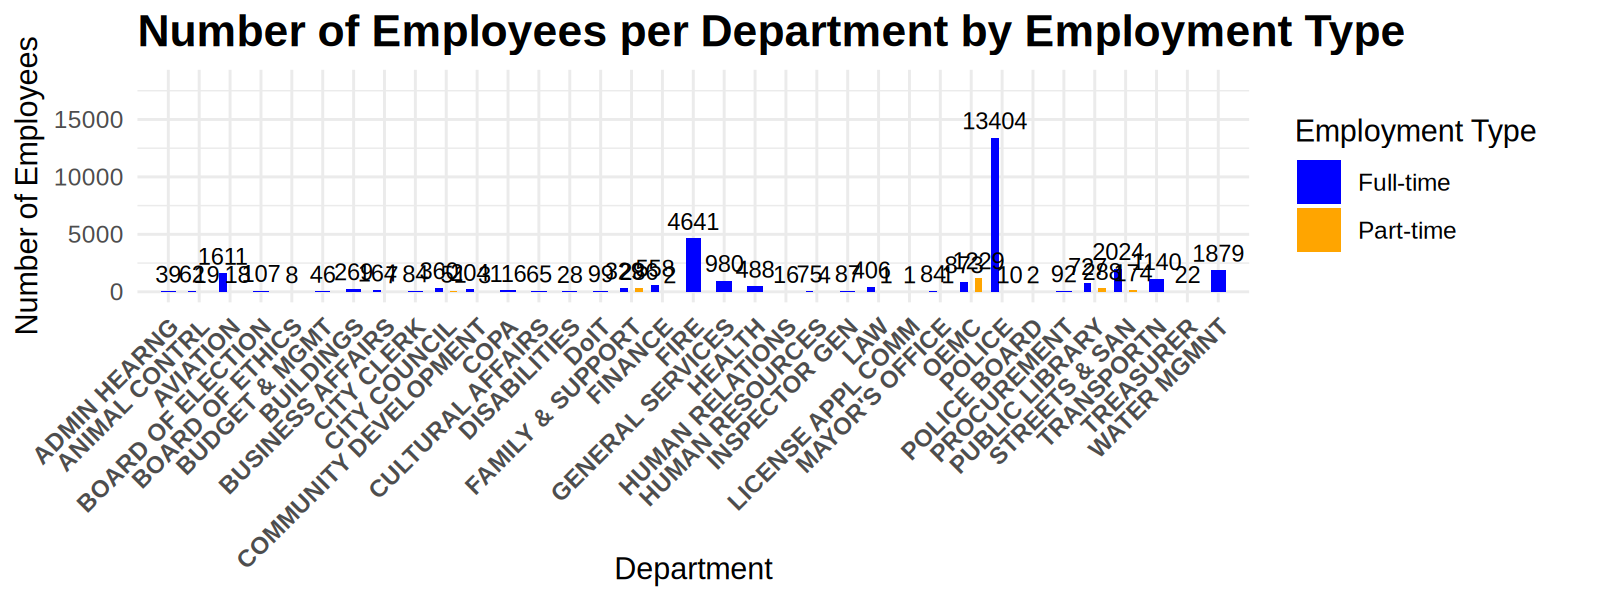

In [8]:
library(dplyr)
library(ggplot2)

# Summarize the data by Department and TimeStatus
dept_summary <- chicsal_df %>%
  mutate(TimeStatus = case_when(
    Time == "F" ~ "Full-time",
    Time == "P" ~ "Part-time",
    TRUE ~ "Undefined"
  )) %>%
  group_by(Department, TimeStatus) %>%
  summarise(count = n(), .groups = "drop")

# Determine max count for y-axis
max_count <- max(dept_summary$count, na.rm = TRUE)

# Plot
ggplot(dept_summary, aes(x = Department, y = count, fill = TimeStatus)) +
  geom_col(position = position_dodge(width = 0.95), width = 0.5) +
  geom_text(aes(label = count), 
            position = position_dodge(width = 0.95), 
            vjust = -0.5, size = 3) +
  scale_fill_manual(values = c("Full-time" = "blue", "Part-time" = "orange")) +
  scale_x_discrete(expand = expansion(add = 1)) +
  scale_y_continuous(limits = c(0, max_count + 5000)) +
  labs(
    title = "Number of Employees per Department by Employment Type",
    x = "Department",
    y = "Number of Employees",
    fill = "Employment Type"
  ) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, face = "bold"),
    plot.title = element_text(face = "bold", size = 16)
  )




In [9]:
library(dplyr)

# Filter for Fire and Police departments
chicsal_filtered <- chicsal_df %>%
  filter(Department %in% c("FIRE", "POLICE"))

head(chicsal_filtered, 5)


Name,JobTitle,Department,Time,PayType,Hours,Salary,Rate,HourlyRate,UnifiedRate
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
"AARON, JEFFERY M",SERGEANT,POLICE,F,Salary,NA,101442,NA,48.77019,48.77019
"AARON, KARINA",POLICE OFFICER (ASSIGNED AS DETECTIVE),POLICE,F,Salary,NA,94122,NA,45.25096,45.25096
"ABBATEMARCO, JAMES J",FIRE ENGINEER-EMT,FIRE,F,Salary,NA,103350,NA,49.68750,49.68750
"ABBATE, TERRY M",POLICE OFFICER,POLICE,F,Salary,NA,93354,NA,44.88173,44.88173
"ABDALLAH, ZAID",POLICE OFFICER,POLICE,F,Salary,NA,84054,NA,40.41058,40.41058


Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_point()`).”


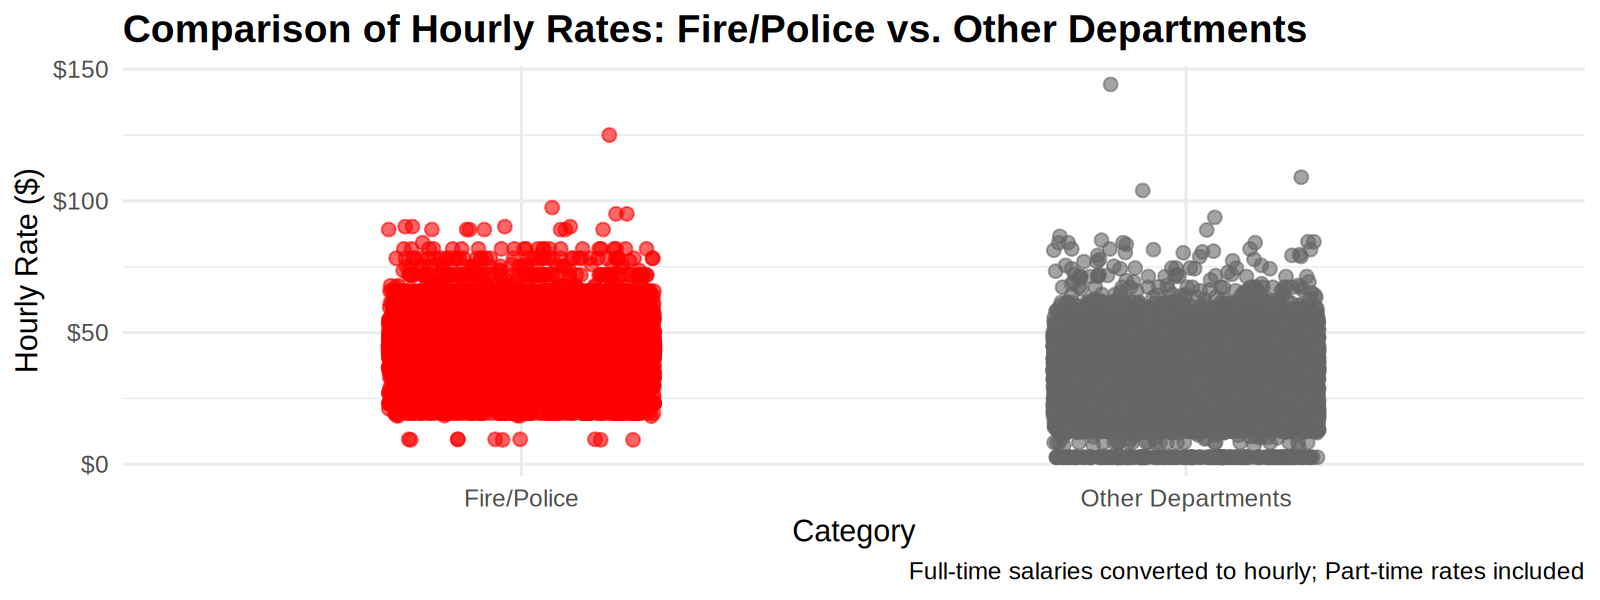

In [10]:
# Create categorical variable
chicsal_df <- chicsal_df %>%
  mutate(
    is_fire_police = if_else(Department %in% c("FIRE", "POLICE"), 1, 0),
    Category = if_else(is_fire_police == 1, "Fire/Police", "Other Departments")
  )

# Scatter plot (with jitter to reduce overlap)
ggplot(chicsal_df, aes(x = Category, y = UnifiedRate, color = Category)) +
  geom_jitter(width = 0.2, alpha = 0.6, size = 2) +  # adds slight horizontal jitter
  scale_color_manual(values = c("Fire/Police" = "red", "Other Departments" = "gray40")) +
  labs(
    title = "Comparison of Hourly Rates: Fire/Police vs. Other Departments",
    x = "Category",
    y = "Hourly Rate ($)",
    color = "Category",
    caption = "Full-time salaries converted to hourly; Part-time rates included"
  ) +
  theme_minimal() +
  scale_y_continuous(labels = scales::dollar_format()) +
  theme(
    plot.title = element_text(face = "bold", size = 14),
    legend.position = "none"
  )


In [11]:
library(stringr)

# Remove foster-related roles and classify Fire/Police vs Others
chicsal_df_clean <- chicsal_df %>%
  # Exclude any job titles with the word "foster" (case insensitive)
  filter(!str_detect(tolower(JobTitle), "foster")) %>%
  mutate(
    is_fire_police = if_else(Department %in% c("FIRE", "POLICE"), 1, 0),
    Category = if_else(is_fire_police == 1, "Fire/Police", "Other Departments")
  )

head(chicsal_df_clean, 5)


Name,JobTitle,Department,Time,PayType,Hours,Salary,Rate,HourlyRate,UnifiedRate,is_fire_police,Category
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
"AARON, JEFFERY M",SERGEANT,POLICE,F,Salary,NA,101442,NA,48.77019,48.77019,1,Fire/Police
"AARON, KARINA",POLICE OFFICER (ASSIGNED AS DETECTIVE),POLICE,F,Salary,NA,94122,NA,45.25096,45.25096,1,Fire/Police
"AARON, KIMBERLEI R",CHIEF CONTRACT EXPEDITER,GENERAL SERVICES,F,Salary,NA,101592,NA,48.84231,48.84231,0,Other Departments
"ABAD JR, VICENTE M",CIVIL ENGINEER IV,WATER MGMNT,F,Salary,NA,110064,NA,52.91538,52.91538,0,Other Departments
"ABASCAL, REECE E",TRAFFIC CONTROL AIDE-HOURLY,OEMC,P,Hourly,20,NA,19.86,19.86000,19.86000,0,Other Departments


Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_boxplot()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_point()`).”


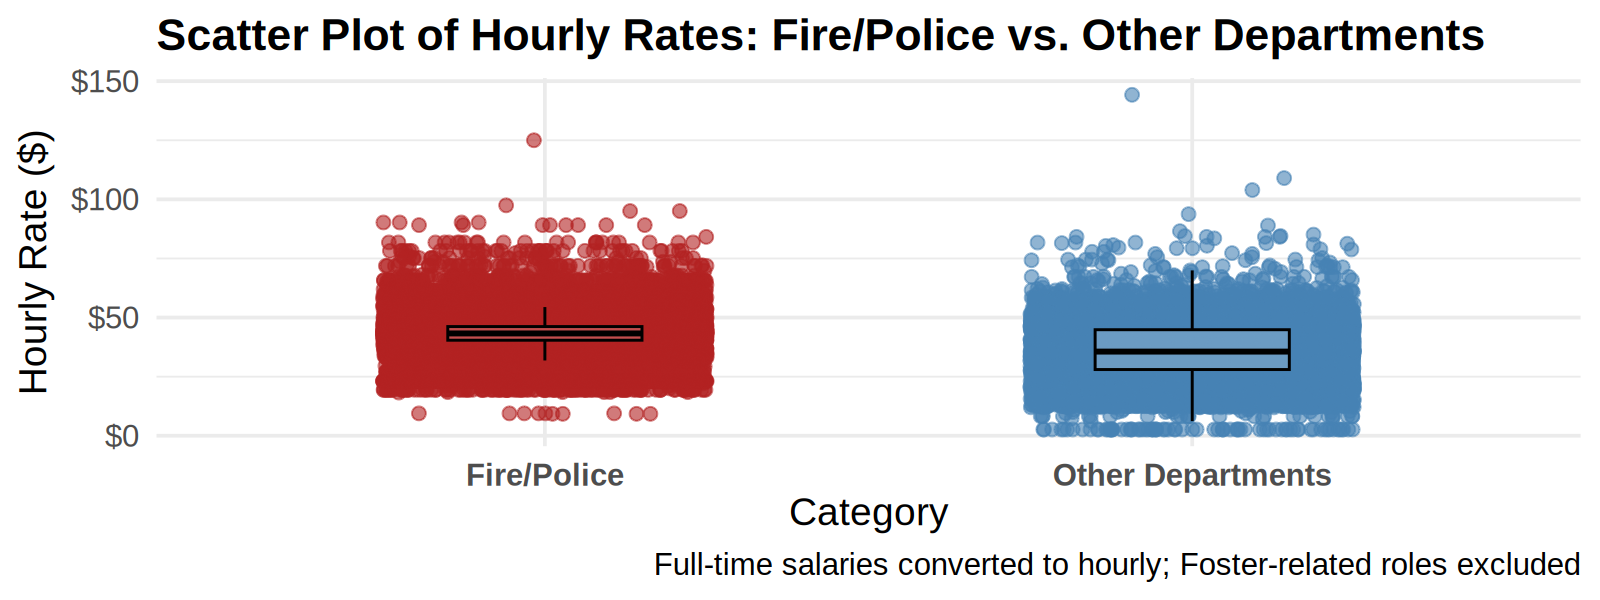

In [12]:


# Clean and categorize dataset
chicsal_clean <- chicsal_df %>%
  # Exclude any job titles containing "foster", "foster grandparent", or "foster parent"
  filter(!str_detect(tolower(JobTitle), "foster")) %>%
  mutate(
    is_fire_police = if_else(Department %in% c("FIRE", "POLICE"), 1, 0),
    Category = if_else(is_fire_police == 1, "Fire/Police", "Other Departments")
  )

# Scatter plot comparison
ggplot(chicsal_clean, aes(x = Category, y = UnifiedRate, color = Category)) +
  geom_jitter(alpha = 0.6, width = 0.25, size = 2) +  # jitter to separate overlapping points
  geom_boxplot(alpha = 0.2, width = 0.3, color = "black", outlier.shape = NA) +  # overlay faint boxplots for reference
  labs(
    title = "Scatter Plot of Hourly Rates: Fire/Police vs. Other Departments",
    x = "Category",
    y = "Hourly Rate ($)",
    caption = "Full-time salaries converted to hourly; Foster-related roles excluded"
  ) +
  scale_color_manual(values = c("Fire/Police" = "firebrick", "Other Departments" = "steelblue")) +
  scale_y_continuous(labels = scales::dollar_format()) +
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(face = "bold", size = 16),
    axis.text.x = element_text(face = "bold"),
    legend.position = "none"
  )


In [13]:
# Linear regression: effect of being Fire/Police on hourly rate
model <- lm(UnifiedRate ~ is_fire_police, data = chicsal_clean)

# Display summary of the regression
summary(model)



Call:
lm(formula = UnifiedRate ~ is_fire_police, data = chicsal_clean)

Residuals:
    Min      1Q  Median      3Q     Max 
-33.709  -4.510   0.302   5.569 108.460 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)    35.77073    0.08563  417.72   <2e-16 ***
is_fire_police  7.20842    0.11587   62.21   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 10.49 on 33052 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.1048,	Adjusted R-squared:  0.1048 
F-statistic:  3870 on 1 and 33052 DF,  p-value: < 2.2e-16
